# 1. First Part of the project, train our own face detection model

In [1]:
!pip install labelme tensorflow opencv-python matplotlib albumentations


[notice] A new release of pip is available: 23.2 -> 24.0
[notice] To update, run: C:\Users\antoi\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [1]:
import os
import time
import uuid
import cv2

Capture pictures to create a dataset

In [140]:
IMAGES_PATH = "C:\Opt\IPSA\AERO_4\S2\ML\Facialrecognition\imageset"
number_images = 30

cap = cv2.VideoCapture(0)
for imgnum in range(number_images): #looping jusqua 30
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read() #ret says if sucess or not
    if not ret:
        break
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Use labelme to fix coordinates of a face on each picture.

In [143]:
!labelme

2024-05-09 10:45:45,331 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\antoi\.labelmerc


In [144]:
import tensorflow as tf
from matplotlib import pyplot as plt

In [146]:
images = tf.data.Dataset.list_files('C:\Opt\IPSA\AERO_4\S2\ML\Facialrecognition\imageset\*.jpg')

In [147]:
images.as_numpy_iterator().next()

b'C:\\Opt\\IPSA\\AERO_4\\S2\\ML\\Facialrecognition\\imageset\\ea50db80-0ddf-11ef-b6e5-4c034fe98b34.jpg'

In [148]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [149]:
images = images.map(load_image)

In [150]:
images.as_numpy_iterator().next()

array([[[122, 135, 128],
        [125, 138, 131],
        [127, 140, 131],
        ...,
        [243, 243, 243],
        [243, 243, 243],
        [243, 243, 243]],

       [[124, 135, 129],
        [125, 138, 131],
        [126, 139, 130],
        ...,
        [243, 243, 243],
        [243, 243, 243],
        [243, 243, 243]],

       [[127, 136, 131],
        [127, 138, 132],
        [127, 138, 130],
        ...,
        [243, 243, 243],
        [243, 243, 243],
        [243, 243, 243]],

       ...,

       [[100, 105,  98],
        [ 99, 104,  97],
        [100, 107,  99],
        ...,
        [120, 111, 116],
        [121, 112, 117],
        [119, 110, 115]],

       [[105, 108,  99],
        [100, 106,  96],
        [100, 107,  99],
        ...,
        [119, 108, 116],
        [121, 110, 118],
        [119, 108, 116]],

       [[105, 108,  99],
        [ 99, 105,  95],
        [ 98, 105,  97],
        ...,
        [116, 105, 113],
        [118, 107, 115],
        [117, 106, 114]]

In [154]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

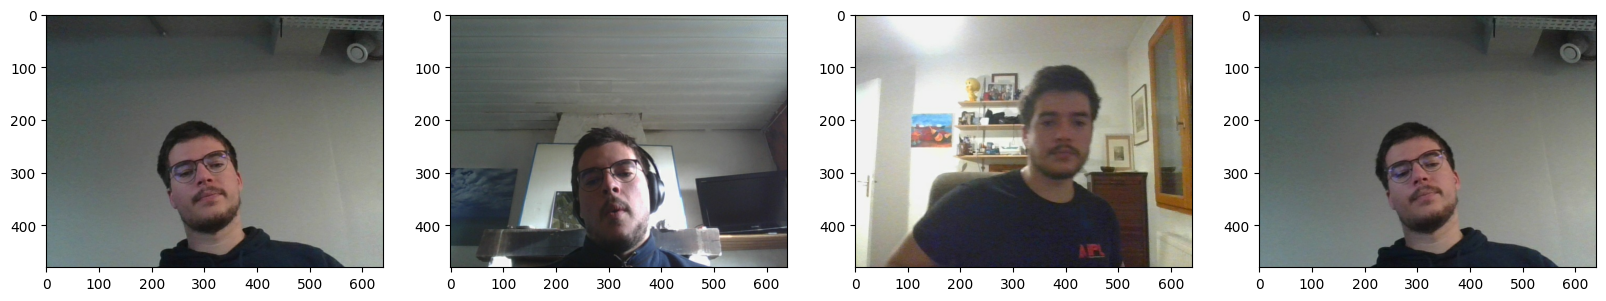

In [155]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

Move the files to different folder "train", "test" and "val"

In [1]:
import os
import shutil
import numpy as np

# Chemins vers les dossiers d'origine
image_dir = 'imageset'
label_dir = 'labelset'

# Chemins vers les dossiers de destination
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

# Créer les dossiers s'ils existent pas
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(directory, 'images'), exist_ok=True)
    os.makedirs(os.path.join(directory, 'labels'), exist_ok=True)

images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
np.random.shuffle(images)  # Mélanger aléatoirement les images

# Définir les proportions de division
n = len(images)
n_train = int(n * 0.7)
n_val = int(n * 0.15)
n_test = n - n_train - n_val

# Diviser les données
train_images = images[:n_train]
val_images = images[n_train:n_train + n_val]
test_images = images[n_train + n_val:]

# Fonction pour copier les fichiers
def copy_files(file_list, src_dir, dest_dir):
    for file in file_list:
        shutil.copy(os.path.join(src_dir, file), os.path.join(dest_dir, 'images', file))
        # Copier également le label correspondant
        label_file = file.replace('.jpg', '.json')
        shutil.copy(os.path.join(label_dir, label_file), os.path.join(dest_dir, 'labels', label_file))

# Copier les fichiers dans les dossiers appropriés
copy_files(train_images, image_dir, train_dir)
copy_files(val_images, image_dir, val_dir)
copy_files(test_images, image_dir, test_dir)


Now we have about 100 pictures but we need more to train our model so we are going to augment our dataset to about 6000 by adding rotation, color change, brightness, random crop etc...

In [157]:
import albumentations as alb

augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [162]:
import cv2
img = cv2.imread(os.path.join('train', 'images','7be21290-0d8a-11ef-a24c-4c034fe98b34.jpg'))

In [163]:
import json

with open(os.path.join('train', 'labels','7be21290-0d8a-11ef-a24c-4c034fe98b34.json'), 'r') as f:
    label = json.load(f)

In [164]:
label['shapes'][0]['points']

[[240.09345794392524, 182.99065420560748],
 [348.5046728971963, 316.63551401869154]]

In [165]:
coords = [0,0,0,0] #we store coordonates in this array
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [166]:
coords

[240.09345794392524, 182.99065420560748, 348.5046728971963, 316.63551401869154]

In [167]:
import numpy as np

height, width, _ = img.shape

coords = list(np.divide(coords, [width, height, width, height]))
coords

[0.3751460280373832, 0.3812305295950156, 0.5445385514018692, 0.659657320872274]

In [177]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [178]:
augmented['image'].shape #ditcionnaire ac infos données au dessus

(450, 450, 3)

In [179]:
augmented['bboxes'][0][2:]

(0.48778816199376956, 0.6614122533748701)

In [180]:
augmented['bboxes']

[(0.24687435098650048,
  0.36442367601246106,
  0.48778816199376956,
  0.6614122533748701)]

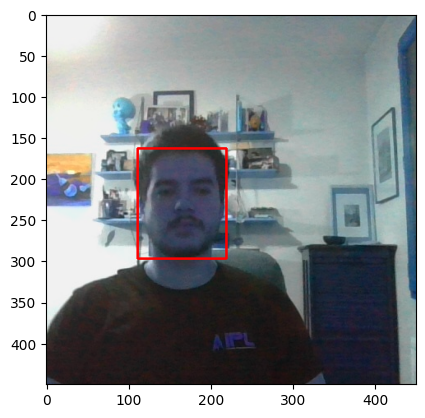

In [183]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),#top coordonates
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), #bottom coordonates
                    (255,0,0), 2)

plt.imshow(augmented['image'])

Augmentation pipeline

In [185]:
for partition in ['train','test','val']: # loop through our 3 folders
    for image in os.listdir(os.path.join(partition, 'images')):# grap every image in these folders
        img = cv2.imread(os.path.join(partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join(partition, 'labels', f'{image.split(".")[0]}.json') # if an annotation or not exists for this image (non positive images) if no anntofation we will add les values ds coords juste au dessus
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            height, width, _ = img.shape

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [width, height, width, height]))

 # then we are creating 60 images per base image
        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face']) #we doing our augmentation
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 #and assign a class of 0 if no annotation neg case


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Training Part

In [186]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (180, 180), method=tf.image.ResizeMethod.BICUBIC))
train_images = train_images.map(lambda x: x/255)
train_images = train_images.map(lambda x: tf.image.adjust_contrast(x, 1.5))

In [187]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (180, 180), method=tf.image.ResizeMethod.BICUBIC))
test_images = test_images.map(lambda x: x/255)

In [188]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (180, 180), method=tf.image.ResizeMethod.BICUBIC))
val_images = val_images.map(lambda x: x/255)

In [189]:
train_images.as_numpy_iterator().next()

array([[[-0.09454212, -0.08723658, -0.08873215],
        [-0.09539506, -0.08801454, -0.08950207],
        [-0.08426878, -0.08119696, -0.0830349 ],
        ...,
        [ 0.40890348,  0.41074473,  0.3965649 ],
        [ 0.40695617,  0.3997444 ,  0.3789301 ],
        [ 0.4193392 ,  0.40957355,  0.38887617]],

       [[-0.05274728, -0.07104564, -0.08001444],
        [-0.04088923, -0.05921221, -0.06817287],
        [-0.04310164, -0.06034857, -0.06966791],
        ...,
        [ 0.40633798,  0.40149188,  0.40020984],
        [ 0.41496974,  0.39891765,  0.3931829 ],
        [ 0.4121754 ,  0.39484632,  0.3865577 ]],

       [[-0.00104448, -0.02326626, -0.03277496],
        [-0.00648087, -0.02835071, -0.03786391],
        [-0.00263566, -0.02422112, -0.03458735],
        ...,
        [ 0.42197984,  0.40403312,  0.40859646],
        [ 0.42457417,  0.4027887 ,  0.40019152],
        [ 0.41170603,  0.3896895 ,  0.38140085]],

       ...,

       [[ 0.40484244,  0.42647415,  0.43011442],
        [ 0

Prepare Labels

In [190]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [191]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [192]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [193]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [194]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.1211 , 0.05347, 0.491  , 0.5884 ], dtype=float16))

Combine Label and Image Samples

In [195]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4860, 4860, 1140, 1140, 1020, 1020)

In [196]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8) #each batch will represent 8 images and 8 labels
train = train.prefetch(4)

In [197]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [198]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [199]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.1047, 0.4446, 0.412 , 0.7915],
        [0.    , 0.2966, 0.2422, 0.901 ],
        [0.5327, 0.4653, 0.7236, 0.7207],
        [0.3782, 0.416 , 0.7114, 0.945 ],
        [0.427 , 0.34  , 0.5576, 0.554 ],
        [0.638 , 0.2888, 0.7837, 0.4966],
        [0.431 , 0.4507, 0.8496, 0.9707],
        [0.4988, 0.2852, 0.679 , 0.547 ]], dtype=float16))

In [200]:
data_samples = train.as_numpy_iterator()
type(data_samples)

tensorflow.python.data.ops.dataset_ops.NumpyIterator

In [201]:
res = data_samples.next()
res[1][1][0]

array([0.5215, 0.4375, 0.7207, 0.705 ], dtype=float16)

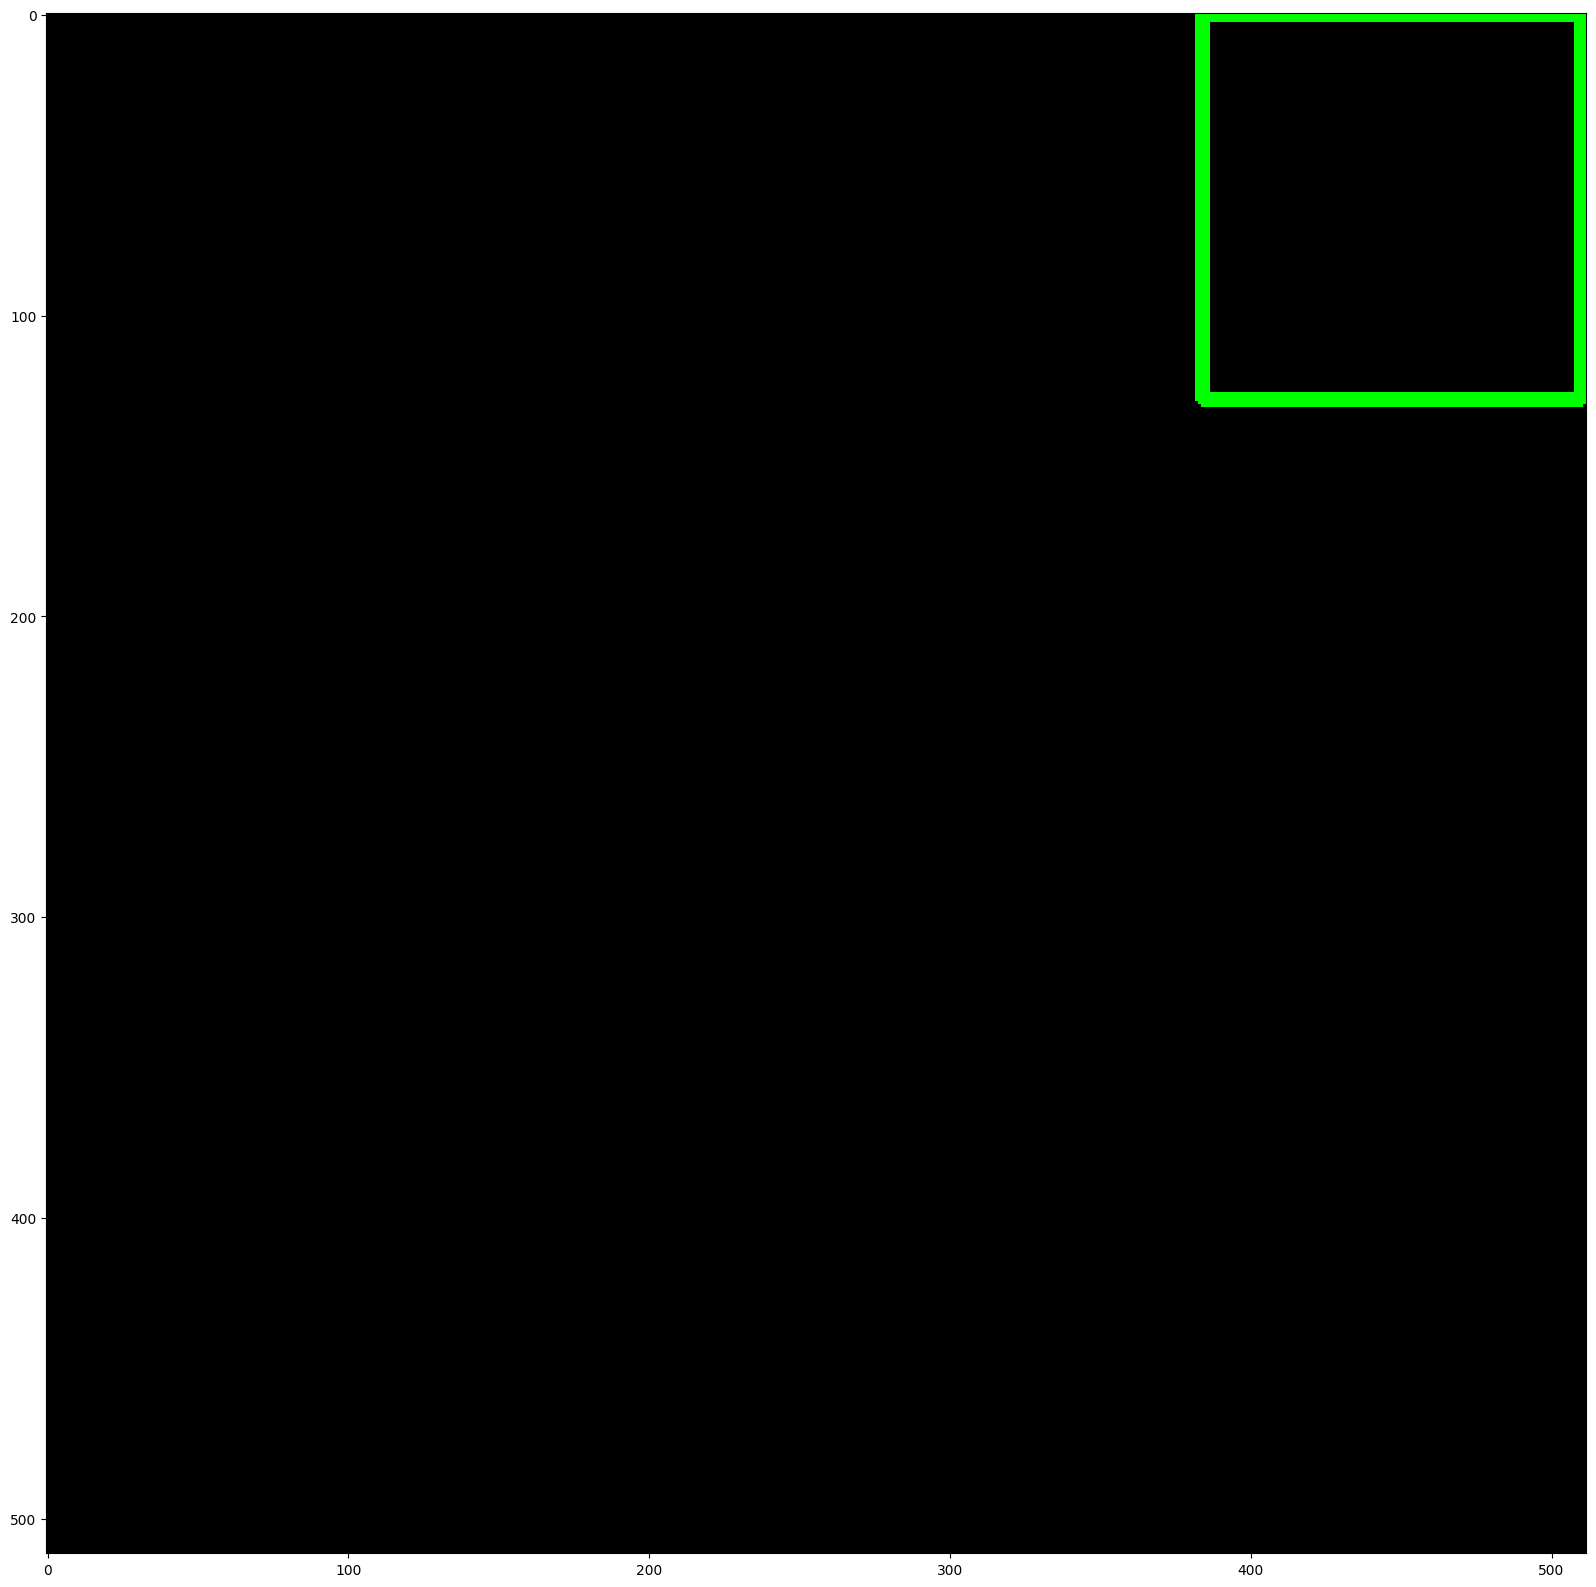

In [202]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

fig, ax = plt.subplots(ncols=1, figsize=(20,20))
img = np.zeros((512,512,3), np.uint8)
cv2.rectangle(img,(384,0),(510,128),(0,255,0),3)
ax.imshow(img)

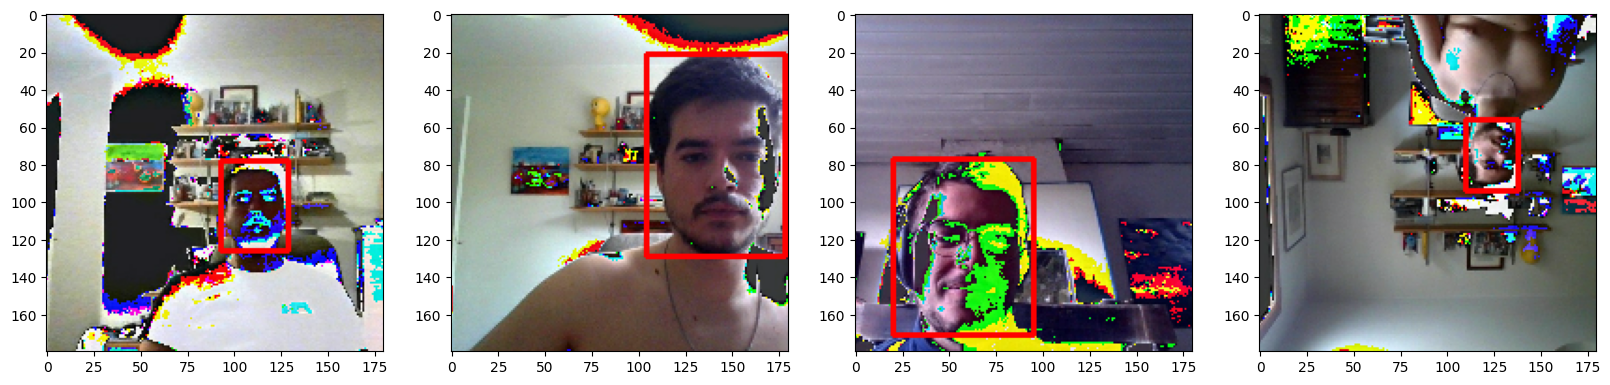

In [203]:
import numpy as np

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = (res[0][idx]*255).astype(np.uint8)
    sample_coords = res[1][1][idx]
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [180,180]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [180,180]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

Build Deep Learning using the Functional API

In [204]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [205]:
vgg = VGG16(include_top=False)

In [206]:
vgg.summary

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x0000027FCB861E10>>

In [213]:
def build_model():
    input_layer = Input(shape=(180,180,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [214]:
facetracker = build_model()

In [215]:
facetracker.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_7[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_4 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [216]:
X, y = train.as_numpy_iterator().next()

In [217]:
X.shape

(8, 180, 180, 3)

In [218]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [219]:
classes, coords

(array([[0.45919243],
        [0.50326616],
        [0.51657933],
        [0.5404137 ],
        [0.55084443],
        [0.5379136 ],
        [0.5294474 ],
        [0.5398009 ]], dtype=float32),
 array([[0.30497694, 0.45894626, 0.35149637, 0.3897909 ],
        [0.5368993 , 0.5809698 , 0.35404545, 0.4429104 ],
        [0.3627499 , 0.551605  , 0.35257816, 0.39555702],
        [0.35276738, 0.44200978, 0.22445571, 0.36368698],
        [0.44239086, 0.55763197, 0.44402206, 0.40118584],
        [0.4342045 , 0.39162484, 0.31057015, 0.39717934],
        [0.36934122, 0.48971936, 0.37688267, 0.31351843],
        [0.34434897, 0.4477447 , 0.4127526 , 0.5234616 ]], dtype=float32))

Define Losses and Optimizers

In [220]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [221]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [222]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [223]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [224]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.4072146>

In [225]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.65121293>

In [226]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.4072146>

Train NN

In [227]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [228]:
model = FaceTracker(facetracker)

In [229]:
model.compile(opt, classloss, regressloss)

In [230]:
logdir='logs'

In [231]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [232]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
608/608 [==============================] - 798s 1s/step - total_loss: 0.1267 - class_loss: 0.0124 - regress_loss: 0.1204 - val_total_loss: 0.0206 - val_class_loss: 1.2357e-04 - val_regress_loss: 0.0206
Epoch 2/10
608/608 [==============================] - 784s 1s/step - total_loss: 0.0282 - class_loss: 0.0048 - regress_loss: 0.0258 - val_total_loss: 0.0133 - val_class_loss: 4.3897e-04 - val_regress_loss: 0.0131
Epoch 3/10
608/608 [==============================] - 786s 1s/step - total_loss: 0.0158 - class_loss: 0.0013 - regress_loss: 0.0151 - val_total_loss: 0.0165 - val_class_loss: 3.1330e-04 - val_regress_loss: 0.0163
Epoch 4/10
608/608 [==============================] - 782s 1s/step - total_loss: 0.0094 - class_loss: 4.2791e-04 - regress_loss: 0.0092 - val_total_loss: 0.0113 - val_class_loss: 1.9794e-04 - val_regress_loss: 0.0112
Epoch 5/10
608/608 [==============================] - 774s 1s/step - total_loss: 0.0072 - class_loss: 1.5840e-04 - regress_loss: 0.0071 - val_to

In [233]:
hist.history

{'total_loss': [0.026034187525510788,
  0.0039928872138261795,
  0.007111584302037954,
  0.002841174602508545,
  0.00575620261952281,
  0.0011352666188031435,
  0.0017616302939131856,
  0.0009765267022885382,
  0.0014558699913322926,
  0.0006835946696810424],
 'class_loss': [0.0001754485274432227,
  0.0002006380818784237,
  0.00029604535666294396,
  3.315615322208032e-05,
  2.6674351829569787e-05,
  2.54221504292218e-05,
  2.4796683646854945e-05,
  2.130905704689212e-05,
  1.0281812592438655e-06,
  6.258492248889524e-07],
 'regress_loss': [0.025946462526917458,
  0.0038925684057176113,
  0.006963561754673719,
  0.002824596595019102,
  0.005742865614593029,
  0.001122555579058826,
  0.0017492319457232952,
  0.0009658721974119544,
  0.0014553559012711048,
  0.0006832817452959716],
 'val_total_loss': [0.02063329890370369,
  0.01329982839524746,
  0.016477324068546295,
  0.01130497083067894,
  0.013784725219011307,
  0.01029278989881277,
  0.006174696143716574,
  0.014376124367117882,
  0.

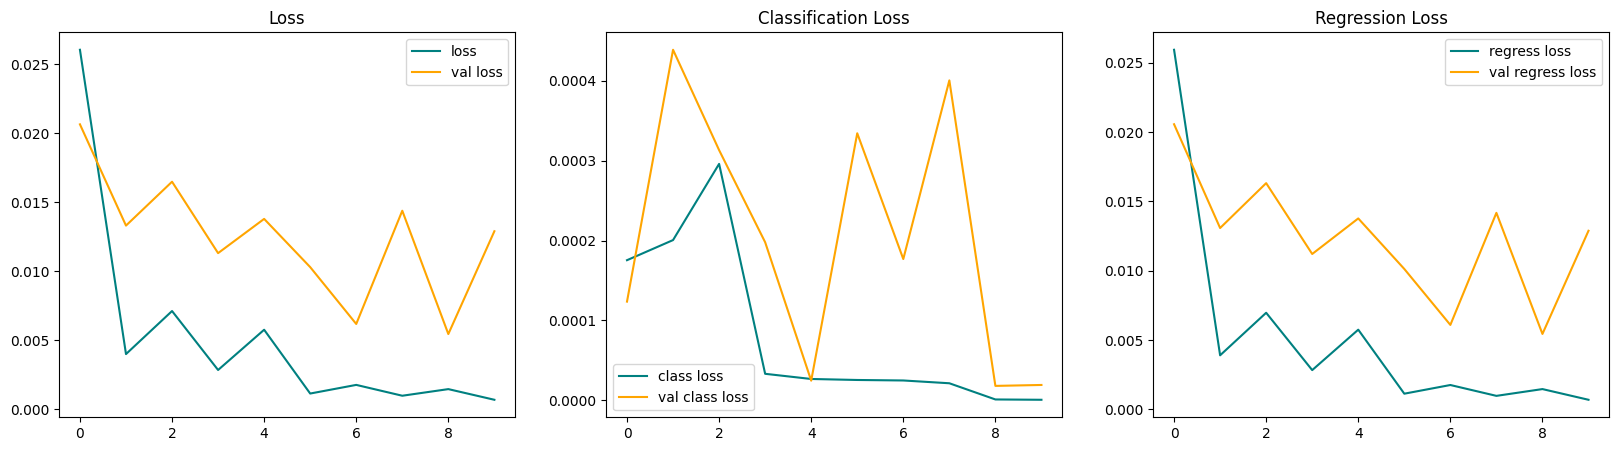

In [234]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [235]:
test_data = test.as_numpy_iterator()

In [236]:
test_sample = test_data.next()

In [237]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 699ms/step


Test our model on image

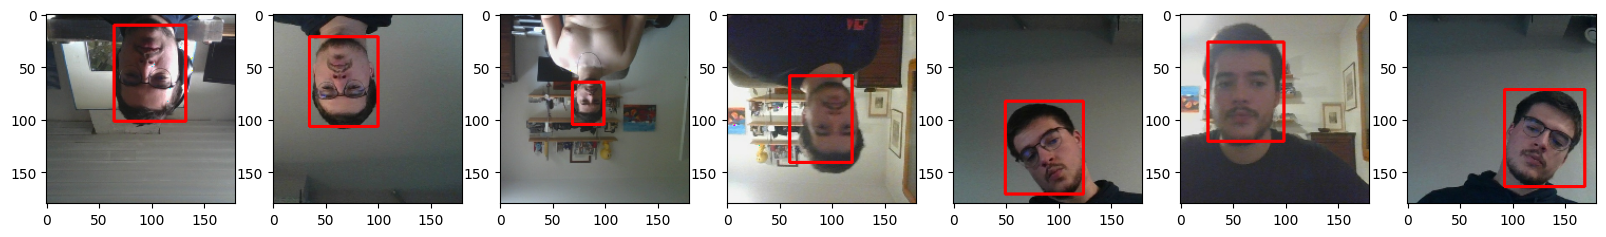

In [238]:
fig, ax = plt.subplots(ncols=7, figsize=(20,20))
for idx in range(7):
    sample_image = (test_sample[0][idx]*255).astype(np.uint8)
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [180,180]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [180,180]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [1]:
from tensorflow.keras.models import load_model

In [240]:
facetracker.save('face_detection_model/facetracker.h5')

C:\Users\antoi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
facetracker = load_model('face_detection_model/facetracker.h5')

In [3]:
import cv2
import numpy as np
import tensorflow as tf

### Running our model on livestream...

In [4]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

while cap.isOpened():
    _, frame = cap.read()
    # Découpe pour se concentrer sur une région spécifique
    frame = frame[40:680, 320:960, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (180,180))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.996:
        coords_rect = tuple(np.multiply(sample_coords[:2], [640, 640]).astype(int))
        coords_rect_end = tuple(np.multiply(sample_coords[2:], [640, 640]).astype(int))

        cv2.rectangle(frame,
                      coords_rect,
                      coords_rect_end,
                      (255, 0, 0), 2)

        cv2.rectangle(frame,
                      tuple(np.add(coords_rect, [0, -30])),
                      tuple(np.add(coords_rect, [80, 0])),
                      (255, 0, 0), -1)

        cv2.putText(frame, 'face', tuple(np.add(coords_rect, [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    else:
        text_size = cv2.getTextSize('No face', cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
        text_x = (frame.shape[1] - text_size[0]) // 2
        text_y = (frame.shape[0] + text_size[1]) // 2

        cv2.putText(frame, 'No face', (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 92ms/step


# 2- Second Part, Development of a connection page + Password with hand movement.

### We are trying other pretrained face detection model to have a better result.

1- MTCNN
2- Blazerface

In [2]:
import cv2
from mtcnn import MTCNN

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
detector = MTCNN()

while cap.isOpened():
    _, frame = cap.read()
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = detector.detect_faces(rgb)

    if results:
        for result in results:
            x, y, width, height = result['box']
            x2, y2 = x + width, y + height

            cv2.rectangle(frame, (x, y), (x2, y2), (255, 0, 0), 2)
            cv2.putText(frame, 'face', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    else:
        text_size = cv2.getTextSize('No face', cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
        text_x = (frame.shape[1] - text_size[0]) // 2
        text_y = (frame.shape[0] + text_size[1]) // 2
        cv2.putText(frame, 'No face', (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()




1/1 [==============================] - 0s 16ms/step


In [3]:
import cv2
import mediapipe as mp

mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

while cap.isOpened():
    success, image = cap.read()
    if not success:
        print("Ignoring empty camera frame.")
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False

    results = face_detection.process(image)

    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.detections:
        for detection in results.detections:
            mp_drawing.draw_detection(image, detection)

    cv2.imshow('MediaPipe Face Detection', image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


### Lets add the hand Detection

In [6]:
import cv2
import mediapipe as mp

mp_face_detection = mp.solutions.face_detection
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)
hands = mp_hands.Hands(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.5)

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

while cap.isOpened():
    success, image = cap.read()
    if not success:
        print("Ignoring empty camera frame.")
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False

    face_results = face_detection.process(image)
    hand_results = hands.process(image)

    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if face_results.detections:
        for detection in face_results.detections:
            mp_drawing.draw_detection(image, detection)

    if hand_results.multi_hand_landmarks:
        for hand_landmarks in hand_results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                mp_drawing.DrawingSpec(color=(250, 44, 250), thickness=2))

    cv2.imshow('MediaPipe Face and Hand Detection', image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


### Lets now add hand gesture recognition.

In [9]:
import csv
import cv2
import mediapipe as mp
import copy
from model import KeyPointClassifier

# Initialisation de MediaPipe
mp_face_detection = mp.solutions.face_detection
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Création des instances de détection
face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)
hands = mp_hands.Hands(max_num_hands=4, min_detection_confidence=0.7, min_tracking_confidence=0.5)

# Chargement des classificateurs
keypoint_classifier = KeyPointClassifier()

with open('model/keypoint_classifier/keypoint_classifier_label.csv',
          encoding='utf-8-sig') as f:
    keypoint_classifier_labels = csv.reader(f)
    keypoint_classifier_labels = [
        row[0] for row in keypoint_classifier_labels
    ]

mode = 0
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

def pre_process_landmark(landmark_list):
    temp_landmark_list = [list(landmark) if landmark is not None else [0, 0] for landmark in landmark_list]

    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0 and landmark_point != [0, 0]:
            base_x, base_y = landmark_point

        temp_landmark_list[index][0] -= base_x
        temp_landmark_list[index][1] -= base_y

    flat_list = list(itertools.chain.from_iterable(temp_landmark_list))

    max_value = max(map(abs, flat_list), default=1)  # Use default=1 to avoid division by zero
    normalized_list = [x / max_value for x in flat_list]

    return normalized_list

def calc_bounding_rect(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_array = np.empty((0, 2), int)

    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)

        landmark_point = [np.array((landmark_x, landmark_y))]

        landmark_array = np.append(landmark_array, landmark_point, axis=0)

    x, y, w, h = cv2.boundingRect(landmark_array)

    return [x, y, x + w, y + h]

def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []


    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

def select_mode(key, mode):
    number = -1
    if 48 <= key <= 57:  # 0 ~ 9
        number = key - 48
    if key == 110:  # n
        mode = 0
    if key == 107:  # k
        mode = 1
    if key == 104:  # h
        mode = 2
    return number, mode

def logging_csv(number, mode, landmark_list):
    if mode == 0:
        pass
    if mode == 1 and (0 <= number <= 9):
        csv_path = 'model/keypoint_classifier/keypoint.csv'
        with open(csv_path, 'a', newline="") as f:
            writer = csv.writer(f)
            writer.writerow([number, *landmark_list])
    return

def draw_bounding_rect(use_brect, image, brect):
    if use_brect:
        cv2.rectangle(image, (brect[0], brect[1]), (brect[2], brect[3]),
                     (0, 0, 0), 1)

    return image

def draw_info_text(image, brect, handedness, hand_sign_text):
    cv2.rectangle(image, (brect[0], brect[1]), (brect[2], brect[1] - 22),
                 (0, 0, 0), -1)

    info_text = handedness.classification[0].label[0:]
    if hand_sign_text != "":
        info_text = info_text + ':' + hand_sign_text
    cv2.putText(image, info_text, (brect[0] + 5, brect[1] - 4),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    return image

def draw_info(image, mode, number):
    mode_string = ['Logging Key Point', 'Logging Point History']
    if 1 <= mode <= 2:
        cv2.putText(image, "MODE:" + mode_string[mode - 1], (10, 90),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1,
                   cv2.LINE_AA)
        if 0 <= number <= 9:
            cv2.putText(image, "NUM:" + str(number), (10, 110),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1,
                       cv2.LINE_AA)
    return image

def draw_landmarks(image, landmark_point):
    if len(landmark_point) > 0:
        # Thumb
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[3]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[3]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[3]), tuple(landmark_point[4]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[3]), tuple(landmark_point[4]),
                (255, 255, 255), 2)

        # Index finger
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[6]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[6]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[6]), tuple(landmark_point[7]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[6]), tuple(landmark_point[7]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[7]), tuple(landmark_point[8]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[7]), tuple(landmark_point[8]),
                (255, 255, 255), 2)

        # Middle finger
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[10]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[10]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[10]), tuple(landmark_point[11]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[10]), tuple(landmark_point[11]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[11]), tuple(landmark_point[12]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[11]), tuple(landmark_point[12]),
                (255, 255, 255), 2)

        # Ring finger
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[14]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[14]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[14]), tuple(landmark_point[15]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[14]), tuple(landmark_point[15]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[15]), tuple(landmark_point[16]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[15]), tuple(landmark_point[16]),
                (255, 255, 255), 2)

        # Little finger
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[18]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[18]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[18]), tuple(landmark_point[19]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[18]), tuple(landmark_point[19]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[19]), tuple(landmark_point[20]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[19]), tuple(landmark_point[20]),
                (255, 255, 255), 2)

        # Palm
        cv2.line(image, tuple(landmark_point[0]), tuple(landmark_point[1]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[0]), tuple(landmark_point[1]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[1]), tuple(landmark_point[2]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[1]), tuple(landmark_point[2]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[5]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[5]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[9]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[9]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[13]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[13]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[17]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[17]),
                (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[0]),
                (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[0]),
                (255, 255, 255), 2)

    # Key Points
    for index, landmark in enumerate(landmark_point):
        if index == 0:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 1:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 2:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 3:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 4:
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 5:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 6:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 7:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 8:
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 9:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 10:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 11:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 12:
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 13:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 14:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 15:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 16:
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 17:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 18:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 19:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 20:
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 0, 0),
                      -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)

    return image

while cap.isOpened():

    key = cv2.waitKey(10)
    number, mode = select_mode(key, mode)

    success, image = cap.read()
    if not success:
        print("Ignoring empty camera frame.")
        continue
    image = cv2.flip(image, 1)  # Mirror display
    debug_image = copy.deepcopy(image)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False

    # Traitement pour la détection de visage et de mains
    face_results = face_detection.process(image)
    hand_results = hands.process(image)

    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Affichage des résultats de la détection de visage
    if face_results.detections:
        for detection in face_results.detections:
            mp_drawing.draw_detection(debug_image, detection)

    # Traitement et affichage des résultats de la détection des mains
    if hand_results.multi_hand_landmarks is not None:
        for hand_landmarks, handedness in zip(hand_results.multi_hand_landmarks, hand_results.multi_handedness):

            # Bounding box calculation
            brect = calc_bounding_rect(debug_image, hand_landmarks)
            # Landmark calculation
            landmark_list = calc_landmark_list(debug_image, hand_landmarks)

            # Conversion to relative coordinates / normalized coordinates
            pre_processed_landmark_list = pre_process_landmark(landmark_list)

            # Write to the dataset file
            logging_csv(number, mode, pre_processed_landmark_list)

            # Hand sign classification
            hand_sign_id = keypoint_classifier(pre_processed_landmark_list)

            # Drawing part
            debug_image = draw_bounding_rect(True, debug_image, brect) #Rectangle
            debug_image = draw_landmarks(debug_image, landmark_list)
            debug_image = draw_info_text(debug_image, brect, handedness, keypoint_classifier_labels[hand_sign_id]) #Affichage du geste

    debug_image = draw_info(debug_image, mode, number)

    cv2.imshow('MediaPipe Face and Hand Detection', debug_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


#### The base model that we are using for hand gesture recognition only has "Ok, Open, Close, Pointer" recognition patern but we want to modify it to have number recognition from 0 to 5 on each hand.

#### For that we are using keypoint_classification_EN.ipynb file to train our model the way we want and we register the coordinates representations of the fingers that show numbers keypoint_classifier_label.csv

#### After training our model, we created a GUI with tkinter and a local database connection called password.db which will store all the user data for the connection platform.

In [10]:
import tkinter as tk
import cv2
import mediapipe as mp
import copy
import itertools
import numpy as np
import csv
from PIL import Image, ImageTk
from model import KeyPointClassifier
import sqlite3

#Fonction pour changer de page et afficher le nom d'utilisateur
def show_frame(frame, username=None):
    if username:
        if frame == register_password_page:
            register_password_username_label.config(text=f"Username: {username}")
        elif frame == password_page:
            password_username_label.config(text=f"Username: {username}")
    frame.tkraise()

#Créer la fenêtre principale avec une taille augmentée
root = tk.Tk()
root.title("Application d'Inscription et de Connexion")
root.attributes('-fullscreen', True)  # Ouvrir en plein écran

# Fonction pour quitter le mode plein écran
def quit_fullscreen(event=None):
    root.attributes('-fullscreen', False)

root.bind("<Escape>", quit_fullscreen)

container = tk.Frame(root)
container.pack(side="top", fill="both", expand=True)
container.grid_rowconfigure(0, weight=1)
container.grid_columnconfigure(0, weight=1)

# Créer les différents pages
home_page = tk.Frame(container)
register_page = tk.Frame(container)
register_password_page = tk.Frame(container)
login_page = tk.Frame(container)
password_page = tk.Frame(container)
dashboard_page = tk.Frame(container)

for frame in (home_page, register_page, login_page, password_page, register_password_page, dashboard_page):
    frame.grid(row=0, column=0, sticky="nsew")

home_label = tk.Label(home_page, text="Bienvenue", font=('Helvetica', 18, 'bold'))
home_label.pack(pady=20)

register_button = tk.Button(home_page, text="S'inscrire", command=lambda: show_frame(register_page))
register_button.pack(pady=10)

login_button = tk.Button(home_page, text="Se connecter", command=lambda: show_frame(login_page))
login_button.pack(pady=10)

register_label = tk.Label(register_page, text="Page d'Inscription", font=('Helvetica', 18, 'bold'))
register_label.pack(pady=20)

username_label_register = tk.Label(register_page, text="Nom d'utilisateur")
username_label_register.pack(pady=5)
username_entry_register = tk.Entry(register_page)
username_entry_register.pack(pady=5)

error_label_register = tk.Label(register_page, text="", fg="red")
error_label_register.pack(pady=5)

to_register_password_page_button = tk.Button(register_page, text="Capturer le mot de passe", command=lambda: check_username_and_proceed())
to_register_password_page_button.pack(pady=10)

back_to_home_from_register = tk.Button(register_page, text="←", font=('Helvetica', 12, 'bold'), command=lambda: show_frame(home_page))
back_to_home_from_register.place(x=10, y=10)

login_label = tk.Label(login_page, text="Page de Connexion", font=('Helvetica', 18, 'bold'))
login_label.pack(pady=20)

username_label_login = tk.Label(login_page, text="Nom d'utilisateur")
username_label_login.pack(pady=5)
username_entry_login = tk.Entry(login_page)
username_entry_login.pack(pady=5)

error_label_login = tk.Label(login_page, text="", fg="red")
error_label_login.pack(pady=5)

capture_password_button = tk.Button(login_page, text="Capturer le mot de passe", command=lambda: check_login_and_proceed())
capture_password_button.pack(pady=10)

back_to_home_from_login = tk.Button(login_page, text="←", font=('Helvetica', 12, 'bold'), command=lambda: show_frame(home_page))
back_to_home_from_login.place(x=10, y=10)

password_label = tk.Label(password_page, text="Capture du Mot de Passe", font=('Helvetica', 18, 'bold'))
password_label.pack(pady=20)

password_username_label = tk.Label(password_page, text="Username: ", font=('Helvetica', 12))
password_username_label.pack(pady=10)

error_label_password = tk.Label(password_page, text="", fg="red")
error_label_password.pack(pady=5)

back_to_login_from_password = tk.Button(password_page, text="←", font=('Helvetica', 12, 'bold'), command=lambda: show_frame(login_page))
back_to_login_from_password.place(x=10, y=10)

video_label = tk.Label(password_page)
video_label.pack()

password_label = tk.Label(password_page, text="Password: ", font=('Helvetica', 12))
password_label.pack(pady=10)

register_password_label = tk.Label(register_password_page, text="Capture du Mot de Passe pour Inscription", font=('Helvetica', 18, 'bold'))
register_password_label.pack(pady=20)

register_password_username_label = tk.Label(register_password_page, text="Username: ", font=('Helvetica', 12))
register_password_username_label.pack(pady=10)

register_password_video_label = tk.Label(register_password_page)
register_password_video_label.pack()

register_password_label = tk.Label(register_password_page, text="Password: ", font=('Helvetica', 12))
register_password_label.pack(pady=10)

back_to_register_from_register_password = tk.Button(register_password_page, text="←", font=('Helvetica', 12, 'bold'), command=lambda: show_frame(register_page))
back_to_register_from_register_password.place(x=10, y=10)

dashboard_label = tk.Label(dashboard_page, text="Tableau de Bord", font=('Helvetica', 18, 'bold'))
dashboard_label.pack(pady=20)

username_label_dashboard = tk.Label(dashboard_page, text="Username: ", font=('Helvetica', 12))
username_label_dashboard.pack(pady=10)

logout_button = tk.Button(dashboard_page, text="Déconnexion", command=lambda: show_frame(home_page))
logout_button.pack(pady=10)

mp_face_detection = mp.solutions.face_detection
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)
hands = mp_hands.Hands(max_num_hands=4, min_detection_confidence=0.7, min_tracking_confidence=0.5)

keypoint_classifier = KeyPointClassifier()

with open('model/keypoint_classifier/keypoint_classifier_label.csv', encoding='utf-8-sig') as f:
    keypoint_classifier_labels = csv.reader(f)
    keypoint_classifier_labels = [row[0] for row in keypoint_classifier_labels]

mode = 0
detected_numbers = []
password = []

#Initialisation de la base de données SQLite
conn = sqlite3.connect('passwords.db')
c = conn.cursor()
c.execute('''CREATE TABLE IF NOT EXISTS users (id INTEGER PRIMARY KEY, username TEXT, password TEXT)''')
conn.commit()


def pre_process_landmark(landmark_list):
    temp_landmark_list = [list(landmark) if landmark is not None else [0, 0] for landmark in landmark_list]
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0 and landmark_point != [0, 0]:
            base_x, base_y = landmark_point
        temp_landmark_list[index][0] -= base_x
        temp_landmark_list[index][1] -= base_y
    flat_list = list(itertools.chain.from_iterable(temp_landmark_list))
    max_value = max(map(abs, flat_list), default=1)
    normalized_list = [x / max_value for x in flat_list]
    return normalized_list

def calc_bounding_rect(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]
    landmark_array = np.empty((0, 2), int)
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        landmark_point = [np.array((landmark_x, landmark_y))]
        landmark_array = np.append(landmark_array, landmark_point, axis=0)
    x, y, w, h = cv2.boundingRect(landmark_array)
    return [x, y, x + w, y + h]

def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]
    landmark_point = []
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        landmark_point.append([landmark_x, landmark_y])
    return landmark_point

def select_mode(key, mode):
    number = -1
    if 48 <= key <= 57:
        number = key - 48
    if key == 110:
        mode = 0
    if key == 107:
        mode = 1
    if key == 104:
        mode = 2
    return number, mode

def logging_csv(number, mode, landmark_list):
    if mode == 0:
        pass
    if mode == 1 and (0 <= number <= 9):
        csv_path = 'model/keypoint_classifier/keypoint.csv'
        with open(csv_path, 'a', newline="") as f:
            writer = csv.writer(f)
            writer.writerow([number, *landmark_list])
    return

def draw_bounding_rect(use_brect, image, brect):
    if use_brect:
        cv2.rectangle(image, (brect[0], brect[1]), (brect[2], brect[3]), (0, 0, 0), 1)
    return image

def draw_info_text(image, brect, handedness, hand_sign_text):
    cv2.rectangle(image, (brect[0], brect[1]), (brect[2], brect[1] - 22), (0, 0, 0), -1)
    info_text = handedness.classification[0].label[0:]
    if hand_sign_text != "":
        info_text = info_text + ':' + hand_sign_text
    cv2.putText(image, info_text, (brect[0] + 5, brect[1] - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    return image

def draw_info(image, mode, number):
    mode_string = ['Logging Key Point', 'Logging Point History']
    if 1 <= mode <= 2:
        cv2.putText(image, "MODE:" + mode_string[mode - 1], (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
        if 0 <= number <= 9:
            cv2.putText(image, "NUM:" + str(number), (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    return image

def draw_landmarks(image, landmark_point):
    if len(landmark_point) > 0:
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[3]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[3]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[3]), tuple(landmark_point[4]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[3]), tuple(landmark_point[4]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[6]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[6]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[6]), tuple(landmark_point[7]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[6]), tuple(landmark_point[7]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[7]), tuple(landmark_point[8]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[7]), tuple(landmark_point[8]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[10]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[10]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[10]), tuple(landmark_point[11]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[10]), tuple(landmark_point[11]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[11]), tuple(landmark_point[12]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[11]), tuple(landmark_point[12]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[14]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[14]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[14]), tuple(landmark_point[15]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[14]), tuple(landmark_point[15]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[15]), tuple(landmark_point[16]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[15]), tuple(landmark_point[16]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[18]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[18]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[18]), tuple(landmark_point[19]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[18]), tuple(landmark_point[19]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[19]), tuple(landmark_point[20]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[19]), tuple(landmark_point[20]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[0]), tuple(landmark_point[1]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[0]), tuple(landmark_point[1]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[1]), tuple(landmark_point[2]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[1]), tuple(landmark_point[2]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[5]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[2]), tuple(landmark_point[5]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[9]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[5]), tuple(landmark_point[9]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[13]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[9]), tuple(landmark_point[13]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[17]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[13]), tuple(landmark_point[17]), (255, 255, 255), 2)
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[0]), (0, 0, 0), 6)
        cv2.line(image, tuple(landmark_point[17]), tuple(landmark_point[0]), (255, 255, 255), 2)
    for index, landmark in enumerate(landmark_point):
        if index == 0:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 1:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 2:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 3:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 4:
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 5:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 6:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 7:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 8:
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 9:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 10:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 11:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 12:
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 13:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 14:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 15:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 16:
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
        if index == 17:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 18:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 19:
            cv2.circle(image, (landmark[0], landmark[1]), 5, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 5, (0, 0, 0), 1)
        if index == 20:
            cv2.circle(image, (landmark[0], landmark[1]), 8, (255, 0, 0), -1)
            cv2.circle(image, (landmark[0], landmark[1]), 8, (0, 0, 0), 1)
    return image

def update_video_frame():
    global mode, detected_numbers
    detected_numbers.clear()
    success, image = cap.read()
    if not success:
        print("Ignoring empty camera frame.")
        root.after(10, update_video_frame)
        return

    image = cv2.flip(image, 1)
    debug_image = copy.deepcopy(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    face_results = face_detection.process(image)
    hand_results = hands.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if face_results.detections:
        for detection in face_results.detections:
            mp_drawing.draw_detection(debug_image, detection)

    if hand_results.multi_hand_landmarks is not None:
        for hand_landmarks, handedness in zip(hand_results.multi_hand_landmarks, hand_results.multi_handedness):
            brect = calc_bounding_rect(debug_image, hand_landmarks)
            landmark_list = calc_landmark_list(debug_image, hand_landmarks)
            pre_processed_landmark_list = pre_process_landmark(landmark_list)
            logging_csv(-1, mode, pre_processed_landmark_list)
            hand_sign_id = keypoint_classifier(pre_processed_landmark_list)
            detected_numbers.append(hand_sign_id)
            debug_image = draw_bounding_rect(True, debug_image, brect)
            debug_image = draw_landmarks(debug_image, landmark_list)
            debug_image = draw_info_text(debug_image, brect, handedness, keypoint_classifier_labels[hand_sign_id])
    debug_image = draw_info(debug_image, mode, -1)

    #Convert the image to a format Tkinter can use
    img = Image.fromarray(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB))
    imgtk = ImageTk.PhotoImage(image=img)

    #Update the image in the label
    if video_label.winfo_ismapped():
        video_label.imgtk = imgtk
        video_label.configure(image=imgtk)

    if register_password_video_label.winfo_ismapped():
        register_password_video_label.imgtk = imgtk
        register_password_video_label.configure(image=imgtk)

    #Schedule the next frame update
    root.after(10, update_video_frame)

def calculate_sum():
    total = sum(detected_numbers)
    return total

def capture_numbers():
    if len(password) < 4:
        if detected_numbers:
            number = calculate_sum()
            password.append(number)
            print(f"Captured number: {number}")
            password_label.config(text=f"Password: {''.join(map(str, password))}")
        root.after(3000, capture_numbers)

def capture_register_numbers():
    if len(password) < 4:
        if detected_numbers:
            number = calculate_sum()
            password.append(number)
            print(f"Captured number: {number}")
            register_password_label.config(text=f"Password: {''.join(map(str, password))}")
        root.after(3000, capture_register_numbers)

def verify_password(username, entered_password):
    c.execute("SELECT password FROM users WHERE username=?", (username,))
    row = c.fetchone()
    if row:
        stored_password = row[0]
        return entered_password == stored_password
    return False

def check_username_and_proceed():
    username = username_entry_register.get()
    c.execute("SELECT * FROM users WHERE username=?", (username,))
    if c.fetchone():
        error_label_register.config(text="Nom d'utilisateur déjà existant.")
    elif len(username) == 0:
        error_label_register.config(text="Le nom d'utilisateur est vide.")
    else:
        show_frame(register_password_page, username)

def check_login_and_proceed():
    global current_username
    username = username_entry_login.get()
    current_username = username
    c.execute("SELECT * FROM users WHERE username=?", (username,))
    if c.fetchone():
        show_frame(password_page, username)
    elif len(username) == 0:
        error_label_login.config(text="Le nom d'utilisateur est vide.")
    else:
        error_label_login.config(text="Nom d'utilisateur non trouvé.")

def reset_password_capture():
    password.clear()
    password_label.config(text="Password: ")
    error_label_password.config(text="")

def attempt_login():
    username = username_entry_login.get()
    if len(password) >= 4:
        password_str = ''.join(map(str, password))
        if verify_password(username, password_str):
            show_frame(dashboard_page, username)
            username_label_dashboard.config(text=f"Username: {username}")
        else:
            error_label_password.config(text="Mot de passe incorrect.")
            reset_password_capture()
    else:
        error_label_password.config(text="Mot de passe incomplet.")

def save_register_password():
    username = username_entry_register.get()
    if len(username) > 0 and len(password) >= 4:
        password_str = ''.join(map(str, password))
        print(f"Saving password for {username}: {password_str}")
        c.execute("INSERT INTO users (username, password) VALUES (?, ?)", (username, password_str))
        conn.commit()
        password.clear()
        register_password_label.config(text="Password: ")
        username_entry_register.delete(0, tk.END)
        show_frame(home_page)

def switch_frame(frame):
    frame.tkraise()

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

root.after(10, update_video_frame)

capture_numbers_button = tk.Button(password_page, text="Capture Numbers", command=capture_numbers)
capture_numbers_button.pack(pady=10)

reset_password_button = tk.Button(password_page, text="Reset", command=reset_password_capture)
reset_password_button.pack(pady=10)

attempt_login_button = tk.Button(password_page, text="Login", command=attempt_login)
attempt_login_button.pack(pady=10)

capture_register_numbers_button = tk.Button(register_password_page, text="Capture Numbers", command=capture_register_numbers)
capture_register_numbers_button.pack(pady=10)

save_register_password_button = tk.Button(register_password_page, text="Register", command=save_register_password)
save_register_password_button.pack(pady=10)

show_frame(home_page)

root.mainloop()

cap.release()
cv2.destroyAllWindows()
conn.close()

Captured number: 1
Captured number: 2
Captured number: 1
Captured number: 2
Saving password for TESTE: 1212
Captured number: 1
Captured number: 2
Captured number: 1
Captured number: 2
